#**Determining wedge position status “ON/OFF”**


During the drilling operations, some manipulations with the drilling tool are constantly performed using a winch. In fact, one can always say that the drilling tool either hangs on the winch hook (and thereby its weight is unloaded by the hoist system of the drill), or is held by the wedges of the rotary shaft (and thereby the entire weight of the drilling tool is unloaded onto the rotary table and winch hook remains weight free).

There is a need to determine the state where the weight of the tool is in wedges or aweight at any given time.


The main parameter for this is the reading of the weight sensor on the hook. It seems that to determine the state you just need to know the current weight, the weight of the empty hook and compare them with each other. However, in practice this is not that easy. Weight indications are subject to dynamic short and long-term deviations. Sometimes it’s difficult even for a person to figure out what happens just by looking at the data. (but nevertheless, an experienced look highlights 99.9% of cases correctly).

Some labeled examples are attached, that can be used for training.

In [1]:
import os
from zipfile import ZipFile
from shutil import copy

In [4]:
fileName = "../data/wedges.zip"
ds = ZipFile(fileName)
ds.extractall()
#os.remove(fileName)
print('Zip file is extracted')

os.chdir('wedges')
#Looking what is inside
!ls -lah

Zip file is extracted


"ls" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


**Definitions:**

The state of the “ON” or “In wedges” position of the wedges is characterized by the absence of additional weight on the rig’s hook, that is, the “hook weight” sensor value is approximately (1) equals to the weight of the hook itself (“empty hook weight”, parameter FHW). This condition is possible when the drilling tool is fixed in the rotor with the help of wedges or when the tool is absent in the well (all is on the surface).

---

*(1) It is possible that on the hook there is an additional weight of one candle (~ 0.7 - 1 t) or one tube (~ 0.2 -0.3 t) of the drilling tool at those times when the candle is disconnected from the rest of the tool, but not yet installed in the rack.*

---
The state of the “OFF” or “aweight” wedges is characterized by the presence of additional weight on the rig’s hook, that is, the sensor ‘weight on hook’ is greater than the hook’s own weight (“empty hook weight”).



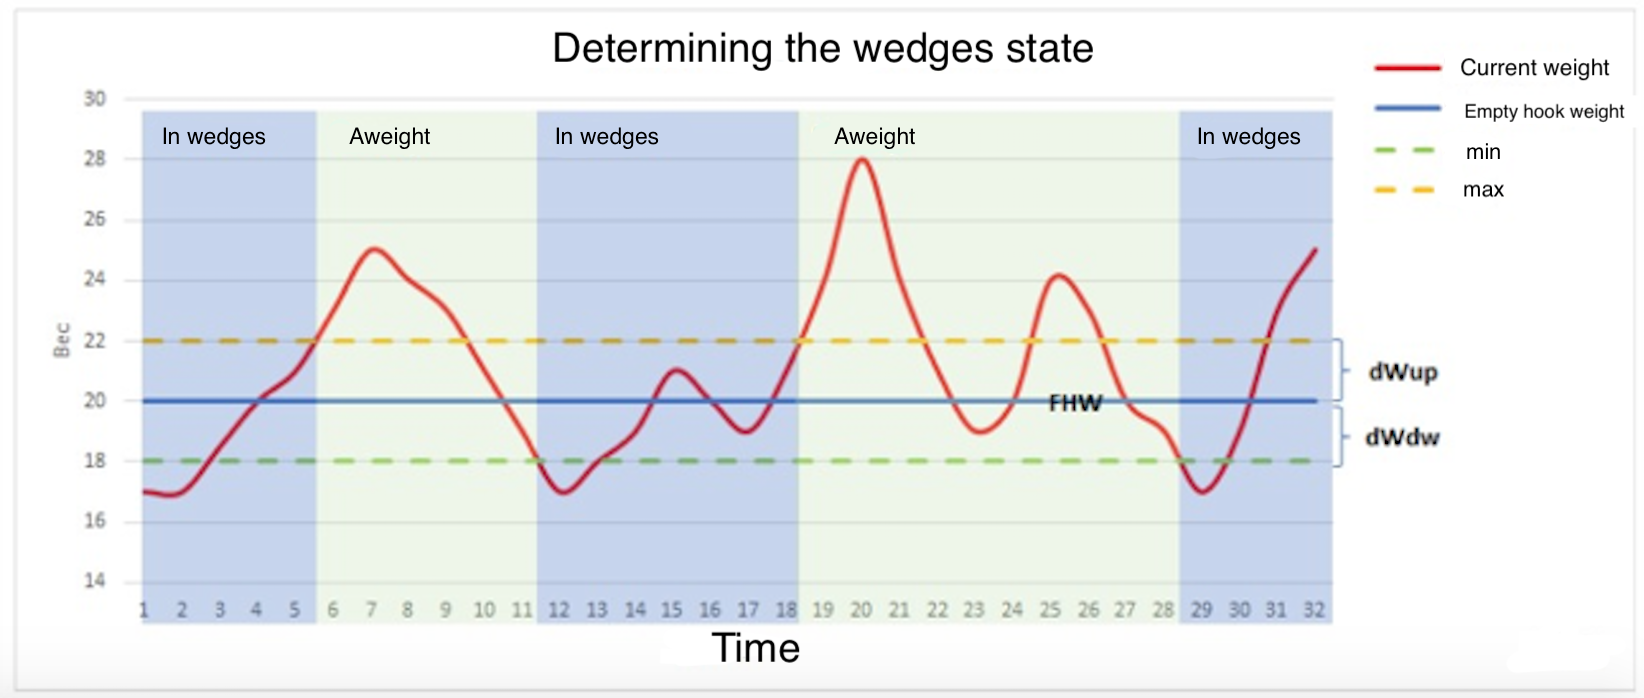

In [5]:
from IPython.display import Image
Image('desc.png')

**Task:**

It is a need to automatically determine the current state of the wedges position (“ON” or “OFF”).
The task is complicated by the fact that the “hook weight” parameter sometimes varies significantly due to various short-term (from seconds to minutes) dynamic effects, such as tool movement, tightening / landing of the drilling tool, vibration of the drilling rig and drilling tool, electromagnetic interference, recalibration of the sensor, as well as long-term (from hours to several days) effects such as temperature drift of the sensor or loosening of the sensor mount.

* SLIPS = ON, - in wedges
* SLIPS = OFF, - aweight

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [7]:
data = pd.read_excel(r'Example_1.xlsx')
data['example'] = 1
data2 = pd.read_excel(r'Example_2.xlsx')
data2['example'] = 2
data3 = pd.read_excel(r'Example_3.xlsx')
data3['example'] = 3
data4 = pd.read_excel(r'Example_4.xlsx')
data4['example'] = 4
data5 = pd.read_excel(r'Example_5.xlsx')
data5['example'] = 5

data = pd.concat([data, data2, data3, data4, data5], sort = False)
data = data.rename(columns = {"Время": "date",
                              "Положение талевого блока, м": "block_position", 
                              "Вес на крюке, т": "weight",
                              "Нагрузка на долото, т": "rotor_load",
                              "Обороты ротора, об/мин": "rotor_turn",
                              "Мех. скорость, м/ч": "rotor_speed",
                              "Давление на входе, кгс/см²": "preasure",
                              
                              "Расход на входе, л/мин": "entry_spend",
                              "Глубина долота, м": "chisels_depth",
                              "Глубина скважины, м": "wells_depth",
                             
                              "Положение талевого блока, м.1": "block_position.1",
                              "Глубина скважины, м.1": "wells_depth.1",
                              "Глубина долота, м.1": "chisels_depth.1",       
                             })

In [14]:
data.head()

,date,block_position,weight,SLIPS,rotor_load,rotor_turn,rotor_speed,preasure,entry_spend,chisels_depth,wells_depth,block_position.1,wells_depth.1,chisels_depth.1,example
0,31 мая 12:15:00,30.01,27.75,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
1,31 мая 12:15:01,30.01,27.75,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
2,31 мая 12:15:02,30.01,26.06,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
3,31 мая 12:15:03,30.01,26.52,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
4,31 мая 12:15:04,30.01,26.52,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18008 entries, 0 to 3601
Data columns (total 15 columns):
date                18008 non-null object
block_position      18008 non-null float64
weight              18008 non-null float64
SLIPS               18008 non-null object
rotor_load          2777 non-null float64
rotor_turn          18008 non-null float64
rotor_speed         2826 non-null float64
preasure            18008 non-null float64
entry_spend         18008 non-null float64
chisels_depth       18008 non-null float64
wells_depth         18008 non-null float64
block_position.1    18008 non-null float64
wells_depth.1       18008 non-null float64
chisels_depth.1     18008 non-null float64
example             18008 non-null int64
dtypes: float64(12), int64(1), object(2)
memory usage: 2.2+ MB


In [16]:
data.describe()

,block_position,weight,rotor_load,rotor_turn,rotor_speed,preasure,entry_spend,chisels_depth,wells_depth,block_position.1,wells_depth.1,chisels_depth.1,example
count,18008.000000,18008.000000,2777.000000,18008.000000,2826.000000,18008.000000,18008.000000,18008.000000,18008.000000,18008.000000,18008.000000,18008.000000,18008.000000
mean,21.151711,51.201529,4.384512,29.224118,39.859133,90.835741,784.151361,2189.788791,3172.311934,21.151711,3172.311934,2189.788791,3.000167
std,10.446671,27.175978,3.030776,54.499468,16.907120,101.243692,1138.279312,1675.433998,1425.420729,10.446671,1425.420729,1675.433998,1.414233
min,0.770000,3.820000,0.100000,0.000000,6.700000,0.000000,0.000000,31.500000,311.610000,0.770000,311.610000,31.500000,1.000000
25%,11.780000,26.380000,1.130000,0.000000,29.620000,0.000000,0.000000,306.927500,3838.810000,11.780000,3838.810000,306.927500,2.000000
50%,24.680000,31.060000,4.560000,0.060000,34.300000,16.830000,0.000000,2834.065000,3900.000000,24.680000,3900.000000,2834.065000,3.000000
75%,30.220000,77.390000,6.990000,9.340000,60.140000,199.910000,907.100000,3839.280000,3900.000000,30.220000,3900.000000,3839.280000,4.000000
max,32.160000,97.170000,13.560000,151.160000,86.280000,260.260000,3523.500000,3892.850000,3900.000000,32.160000,3900.000000,3892.850000,5.000000


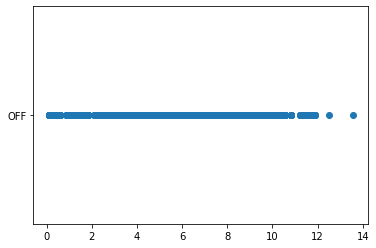

In [17]:
plt.scatter(data["rotor_load"], data["SLIPS"])

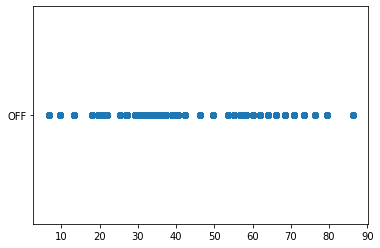

In [18]:
plt.scatter(data["rotor_speed"], data["SLIPS"])

In [22]:
data[~data["SLIPS"]].info()

SyntaxError: invalid syntax (<ipython-input-22-5a822f458fcf>, line 1)

In [ ]:
def converter(datestring):
    res = datestring.split(' ')

    for old, new in [('янв', '01'), ('фев', '02'), ('мар', '03'), ('апр.', '04'), 
                     ('мая', '05'), ('июн', '06'), ('июл', '07'), ('авг', '08'), 
                     ('сен', '09'), ('окт', '10'), ('ноя', '11'), ('дек', '12')]:
        res[1] = res[1].replace(old, new)
    
    result = '2019' + "-" + res[1]  + "-" + res[0] + ' ' + res[2]
    return result

data['date'] = data['date'].apply(converter)
data["date"] = pd.to_datetime(data["date"])
data['SLIPS'] = data['SLIPS'].str.contains('ON').astype(bool)


Check:
* Data Types
* Shape of the dataset
* Null values - identify the columns to drop based on the % of missing values
* Distribution of values for each variable
* Check if some variables have identical values
* Drop redundant/useless data from the dataset


In [ ]:
#YOUR CODE HERE

In [ ]:
#Show data once again
data.head()